# Tutorial on single-cell trajectory alignment using Genes2Genes

G2G aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

In [1]:
import matplotlib.pyplot as plt
import gseapy as gp

def GO_plot(gene_list, gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'Reactome_2022'], 
            display_table=False, title_suffix=None, sort_by='Combined Score', n_rank = 10, n_genes=None, FDR=None):
    """
    Generate GO plots and optionally display tables based on enrichment analysis.

    Parameters:
    - gene_list: List of gene names as strings
    - gene_sets: List of gene set names as strings
    - display_table: Boolean flag to display table or not
    - title_suffix: Suffix for the plot title
    - sort_by: Column name to sort the results and plot. Other options in table, e.g. 'n_genes'
    - n_rank: number of terms to include in plot
    """
    
    # Perform enrichment analysis
    enr_res = gp.enrichr(gene_list=gene_list,
                         gene_sets=gene_sets,
                         organism='human',
                         outdir=None)
    
    # Loop through each gene set to process and plot the results
    for geneset in gene_sets:
        print(geneset)
        
        # Filter the results based on the Gene_set
        df = enr_res.results[enr_res.results['Gene_set'] == geneset]
        
        # Calculate the number of genes in the overlap and add as a new column
        df['n_genes'] = [int(x.split('/')[0]) for x in df['Overlap']]
        
        # Sort the dataframe based on the specified column
        df = df.sort_values(sort_by, ascending=False)

        # Only use terms where a threshold number of genes are present
        if n_rank is not None:
            df = df[df.n_genes>=n_genes]

        if FDR is not None:
            df = df[df['Adjusted P-value']<FDR]
        
        # Optionally display the table
        if display_table:
            display(df[:30])
        
        # Generate the bar plot for the top 10 ranked terms
        plt.rcParams['axes.grid'] = False
        plt.rcParams['figure.figsize'] = 4, 3
        plt.barh(width=df[:n_rank][sort_by],
                 y=[x.split(' (')[0] for x in df[:n_rank]['Term']],
                 color='darkred')
        plt.gca().invert_yaxis()
        plt.xlabel(sort_by)
        if title_suffix:
            plt.title(f'{geneset}_{title_suffix}')
        else:
            plt.title(f'{geneset}')
        plt.margins(y=0.02)
        plt.show()
        
    return df

In [2]:
import anndata

def split_adata_by_modality(adata, modality_column, modality_values):
    """
    Splits an AnnData object into multiple AnnData objects based on a given modality column.
    
    Parameters:
        adata (anndata.AnnData): The original AnnData object.
        modality_column (str): The name of the column in adata.var that contains the modality information.
        modality_values (list): List of unique modalities that you want to split the adata into.
        
    Returns:
        dict: A dictionary where the keys are the modality names and the values are the new AnnData objects.
    """
    # Initialize an empty dictionary to hold the new AnnData objects
    splitted_adatas = {}
    
    # Loop through each modality value to create a new AnnData object
    for modality in modality_values:
        # Get the indices of the features belonging to the current modality
        feature_idx = adata.var[modality_column] == modality
        
        # Create a new AnnData object with only the features belonging to the current modality
        new_adata = anndata.AnnData(X=adata[:, feature_idx].X,
                                    obs=adata.obs,
                                    var=adata.var.loc[feature_idx],
                                    obsm=adata.obsm,
                                    uns=adata.uns)
        
        # Add the new AnnData object to the dictionary
        splitted_adatas[modality] = new_adata
    
    return splitted_adatas

In [3]:
import scanpy as sc
import anndata
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import platform
from optbinning import ContinuousOptimalBinning
import pandas as pd


from genes2genes import Main
from genes2genes import VisualUtils
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyserV2

print(platform.python_version())

3.8.18


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Load the reference and query anndata objects

In [5]:
temporal_ordering='age_days_smoothed_once'

In [6]:
paired_adata_with_time_path = "/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired_with_time.h5ad"

In [7]:
adata=sc.read(paired_adata_with_time_path)
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', 'milesto

In [8]:
adata.obs["time"]=adata.obs['t'].copy()

In [9]:
adata.X.data[:5]

array([2., 1., 1., 1., 1.], dtype=float32)

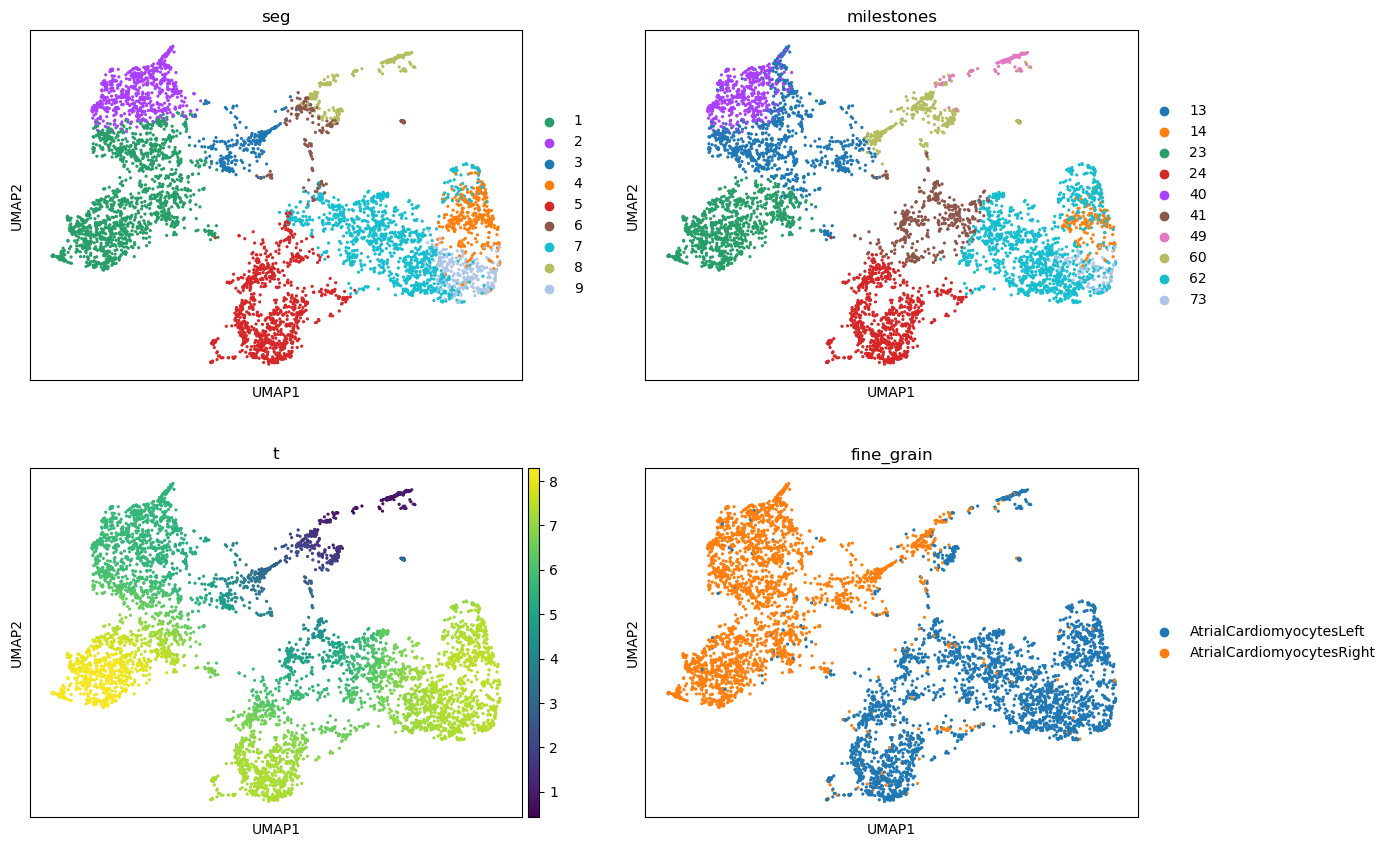

In [10]:
sc.pl.umap(adata,color=["seg","milestones","t","fine_grain"],ncols=2)

In [11]:
modality_column = "modality"
modality_values = ["Gene Expression", "Peaks"]
splitted_adatas = split_adata_by_modality(adata, modality_column, modality_values)

adata_gex = splitted_adatas["Gene Expression"]
print(adata_gex)

adata_atac = splitted_adatas["Peaks"]
print(adata_atac)

AnnData object with n_obs × n_vars = 5664 × 36601
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 'time'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', '

# Make AUC objects

In [12]:
path_to_auc_gene="/nfs/team205/heart/pyscenic/plus/AUCscore/foetal_aCM_n570_eRegulon_AUC_gene.csv"
path_to_auc_region="/nfs/team205/heart/pyscenic/plus/AUCscore/foetal_aCM_n570_eRegulon_AUC_region.csv"

In [13]:
# read in regulon scores
auc_gene = pd.read_csv(path_to_auc_gene, index_col=0)
print(auc_gene.shape)
auc_region = pd.read_csv(path_to_auc_region, index_col=0)
print(auc_region.shape)

(17302, 278)
(12964, 278)


In [14]:
# make regulon adata, AUC gene
# AUC Gene
# create anndata
adata_aucg = anndata.AnnData(
    X=auc_gene.loc[adata_gex.obs_names],
    obs=adata_gex.obs,
    var=pd.DataFrame(auc_gene.columns).set_index(0),
    obsm=adata_gex.obsm,
    uns= adata_gex.uns
)
# modify varnames
adata_aucg.var_names = [x.split('_(')[0] for x in adata_aucg.var_names]
print(adata_aucg.shape)

# AUC Region
# create anndata
adata_aucr = anndata.AnnData(
    X=auc_region.loc[adata_gex.obs_names],
    obs=adata_gex.obs,
    var=pd.DataFrame(auc_region.columns).set_index(0),
    obsm=adata_gex.obsm
)
# modify varnames
adata_aucr.var_names = [x.split('_(')[0] for x in adata_aucr.var_names]
print(adata_aucr.shape)

(5664, 278)
(5664, 278)


At this point we have 4 objects
- adata_gex
- adata_atac
- adata_aucg
- adata_aucr

each has a per cell value (expression or score) for different types of features, and each has the same cells (with psudotemporal ordering in `t`)

# Split into REF and QUERY

In [15]:
# split intlo REF and QUERY
adata_ref=adata_aucg[adata_aucg.obs.fine_grain=="AtrialCardiomyocytesLeft"].copy()
adata_query=adata_aucg[adata_aucg.obs.fine_grain=="AtrialCardiomyocytesRight"].copy()

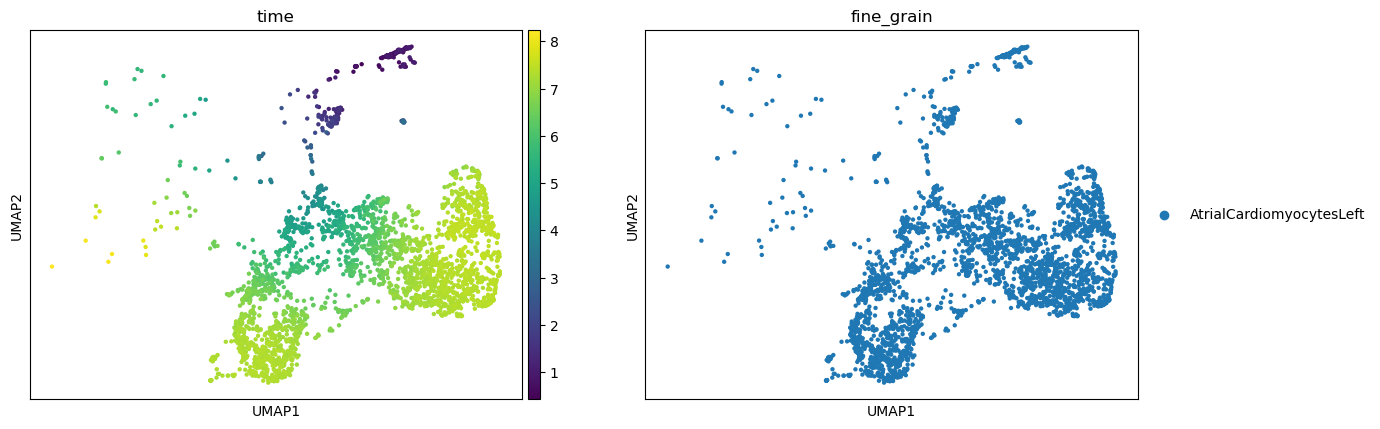

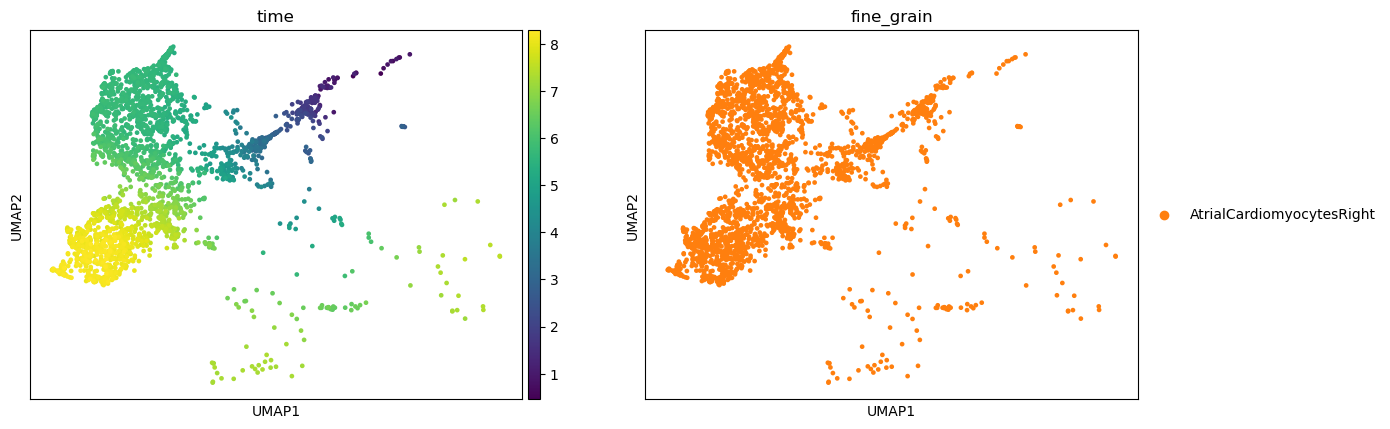

In [16]:
sc.pl.umap(adata_ref,color=["time","fine_grain"],ncols=2)
sc.pl.umap(adata_query,color=["time","fine_grain"],ncols=2)

In [17]:
print(adata_ref)
print(adata_query)

AnnData object with n_obs × n_vars = 3041 × 278
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 'time'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_li

### Min max normalize the pseudotime

In [18]:
# check the current range
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

# if it does not follow [0,1] range, run below
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.4222375414474298 8.245970642037001
0.45019867983228623 8.303595486512195


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


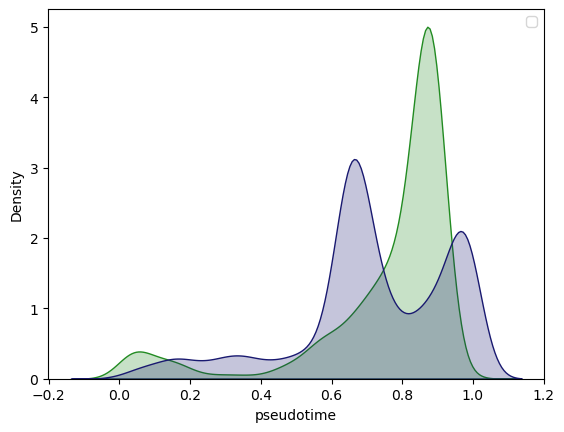

In [19]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend(); plt.show()

### Check the number of bins in the optimal binning structure using OptBinning package

In [20]:
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

12
14


OptBinning estimates 14 optimal number of splits for both reference and query pseudotime distributions. Therefore we choose the same number of interpolation points.

### Visualize the interpolation binning structure in terms of the cell type composition 

For this dataset, we use the author-given time annotations (1h,2h,4h,6h) as the cell-type annotations. 

Next we define a colormap of our choice for these annotations, and call the below function. 

In [21]:
col = np.array(sb.color_palette('colorblind'))[range(2)]
col

array([[0.00392157, 0.45098039, 0.69803922],
       [0.87058824, 0.56078431, 0.01960784]])

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


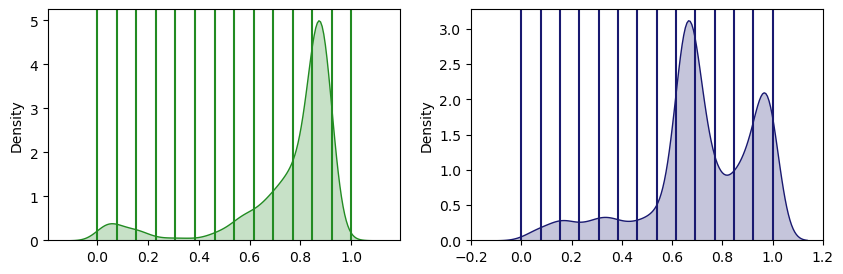

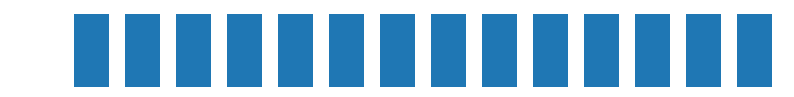

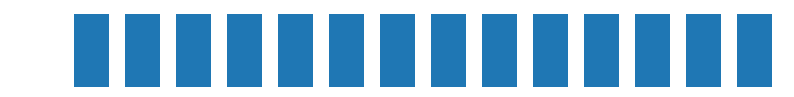

In [22]:
joint_cmap={'AtrialCardiomyocytesLeft':col[0], 'AtrialCardiomyocytesRight':col[1]}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=14, 
                                     ANNOTATION_COLNAME='fine_grain', optimal_binning=False)

### Run G2G alignment

This is done by first creating an aligner object, passing and setting all relevant parameters.
Next we align all gene pairs. (This step is parallelizing indepedenent gene-alignments to make the process time-efficient, however the computational time for an individual alignment will increase as the number of cells and/or the number of interpolation time points increase. 

In [23]:
gene_list = adata_ref.var_names
print(len(gene_list))

278


In [24]:
gene_list[:10]

Index(['ARID3A_extended_-', 'ARNT2_+', 'ARNTL_+', 'ARNT_+', 'ATF1_+', 'ATF2_+',
       'ATF3_+', 'ATF6_extended_+', 'ATF7_+', 'BCL6_+'],
      dtype='object')

In [25]:
%%time

import os
import pickle

# Path for the folder and file
folder_path = '/nfs/team205/jc48/projects/fetal/code/g2g_aligners'
file_path = os.path.join(folder_path, 'AUCgene_aligner.pkl')

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Check if the file already exists
if os.path.isfile(file_path):
    # Read the aligner object from the file
    print("this specific aligner already exists, reading it in...")
    with open(file_path, 'rb') as file:
        aligner = pickle.load(file)
else:
    # If the file does not exist, create and configure the aligner
    print("aligner not already made, making it...")
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE = 0.1
    aligner.state_params = [0.99, 0.1, 0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T

    # Align all pairs
    aligner.align_all_pairs()

    # Save the aligner object to the file
    with open(file_path, 'wb') as file:
        pickle.dump(aligner, file)


this specific aligner already exists, reading it in...
CPU times: user 646 ms, sys: 66.9 ms, total: 713 ms
Wall time: 751 ms


Now we can check the aggregate (average) alignment across all genes:

Average Alignment:  IIIDIDIDDIDDMMMMMMMM


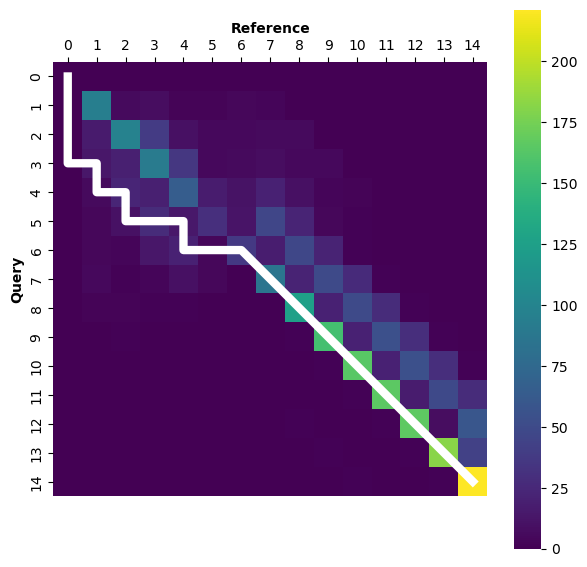

In [26]:
aligner.get_aggregate_alignment()

We can also visualize this alignment in terms of cell-type composition

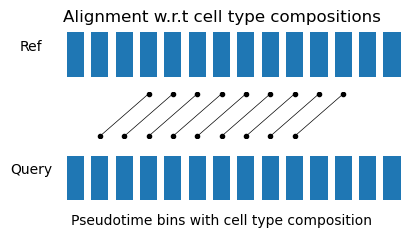

In [27]:
vs.visualize_gene_alignment("IDDDMMMMMMMMMIIIDID")#, cmap=joint_cmap)

We can also visualize an individual gene (e.g. JUNB), displaying its alignment statistics

### The alignment distribution across all genes 

We can use the alignment similarity percentage statistic of genes to rank genes from highly distant to highly similar

mean matched percentage: 
60.519999999999996 %


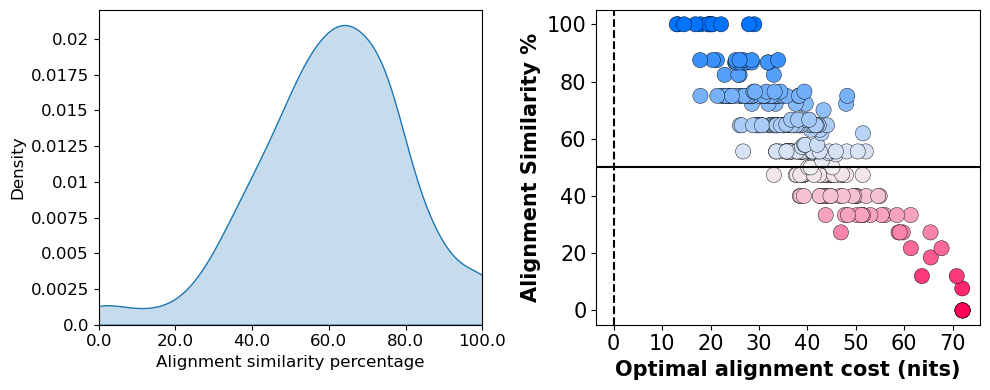

In [28]:
df = aligner.get_stat_df() 

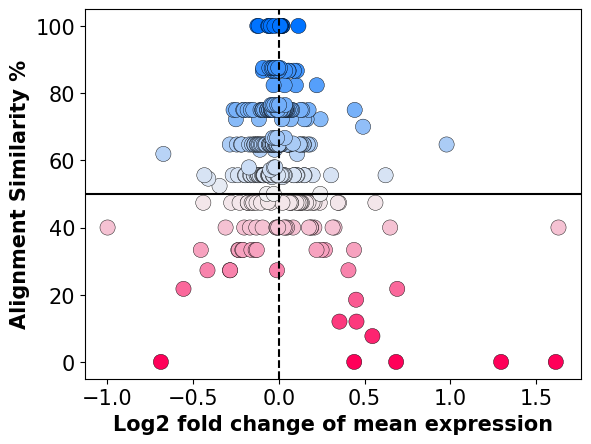

In [29]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

In [30]:
df

Gene alignment_similarity_percentage opt_alignment_cost  \
32              ETS2_-                             0.0          72.073285   
78               MAF_-                             0.0          72.073285   
31              ETS2_+                             0.0          72.073285   
119            PITX2_+                             0.0          72.073285   
35              ETV6_+                             0.0          72.073285   
..                 ...                             ...                ...   
118  PHF21A_extended_+                             1.0          16.884385   
152              TBP_+                             1.0          22.178514   
162            TFCP2_+                             1.0           13.01172   
262           ZNF709_+                             1.0          14.538414   
177           ZBTB20_+                             1.0          27.927091   

         l2fc  color  abs_l2fc  
32   1.615218    red  1.615218  
78   1.296242    red  1.296242  
31  -0.687252    red  0.687252  
119   0.68402    red   0.68402  
35   0.439772    red  0.439772  
..        ...    ...       ...  
118   0.02006  green   0.02006  
152  0.011962  green  0.011962  
162  0.011771  green  0.011771  
262  0.009825  green  0.009825  
177  0.007007  green  0.007007  

[278 rows x 6 columns]

In [31]:
df[(df["alignment_similarity_percentage"]<0.5)&(df["abs_l2fc"]>0)].sort_values('alignment_similarity_percentage', ascending=True)

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
32     ETS2_-                             0.0          72.073285  1.615218   
78      MAF_-                             0.0          72.073285  1.296242   
31     ETS2_+                             0.0          72.073285 -0.687252   
119   PITX2_+                             0.0          72.073285   0.68402   
35     ETV6_+                             0.0          72.073285  0.439772   
..        ...                             ...                ...       ...   
217  ZNF362_+                          0.4737          39.286623   0.35137   
94     MXD1_+                          0.4737          44.536244 -0.440041   
85    MEF2A_-                          0.4737          33.093173   0.56344   
277  ZSCAN9_+                          0.4737          37.808599  0.159698   
201  ZNF207_+                          0.4762          47.165072 -0.062322   

    color  abs_l2fc  
32    red  1.615218  
78    red  1.296242  
31    red  0.687252  
119   red   0.68402  
35    red  0.439772  
..    ...       ...  
217   red   0.35137  
94    red  0.440041  
85    red   0.56344  
277   red  0.159698  
201   red  0.062322  

[77 rows x 6 columns]

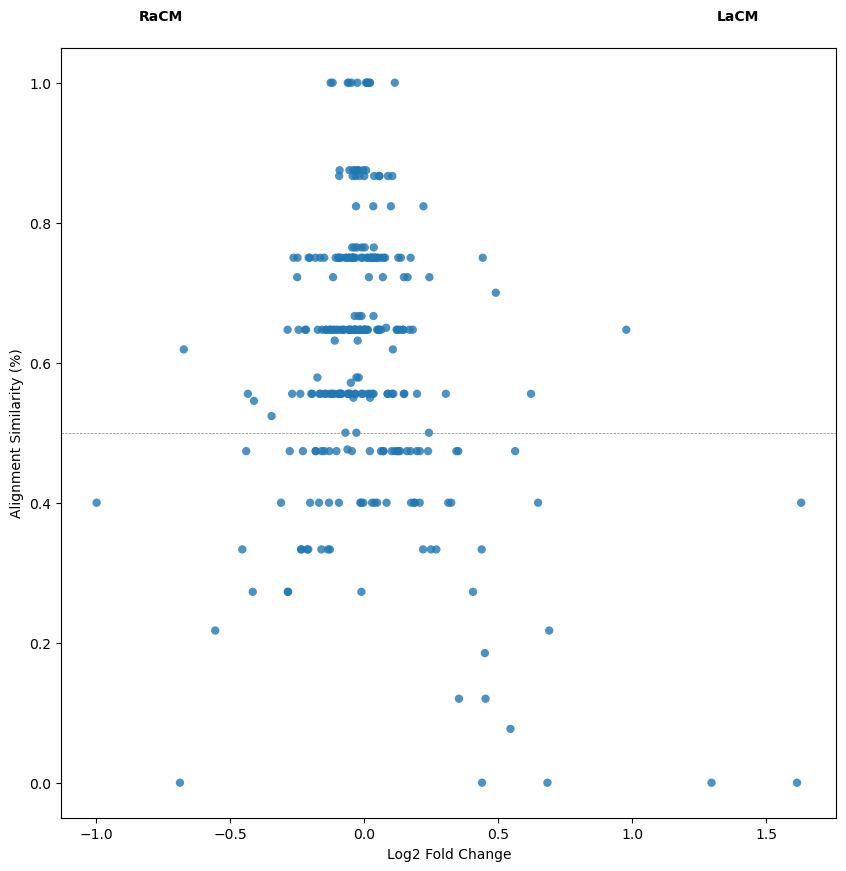

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))


#y_axis = 'opt_alignment_cost'
y_axis = 'alignment_similarity_percentage'

sns.scatterplot(data=df, x='l2fc', y=y_axis, edgecolor="none",legend=False, alpha=0.8)

# Add a horizontal line at y=0.5
plt.axhline(0.5, color='gray', linestyle='--', linewidth = 0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')


# Set labels
plt.xlabel("Log2 Fold Change")

if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")

if y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Save the plot
#plt.savefig("similarity_v_logFC.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [33]:
query_color = 'orange'
ref_color = 'blue'

def plotTimeSeries_cmap(gene, aligner, plot_cells = False, plot_mean_trend= False):
    
        al_obj = aligner.results_map[gene]
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment_cmap(gene, aligner) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(aligner.ref_mat[al_obj.gene])), np.max(np.asarray(aligner.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(aligner.ref_mat[al_obj.gene])), np.min(np.asarray(aligner.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=aligner.query_time, y=np.asarray(aligner.query_mat[al_obj.gene]), alpha=0.7, color = query_color, legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=aligner.ref_time, y=np.asarray(aligner.ref_mat[al_obj.gene]), color = ref_color, alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])

def plotTimeSeriesAlignment_cmap(gene, aligner):  
    
        al_obj = aligner.results_map[gene]
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = ref_color ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = query_color ,alpha=0.05, legend=False)#, label ='Query') 
        plot_mean_trends(al_obj)
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)

def plot_mean_trends(al_obj):
    # Plotting the mean trends for S and T with specified colors
    al_obj.S.plot_mean_trend(color=ref_color)
    al_obj.T.plot_mean_trend(color=query_color)

ETS2_-


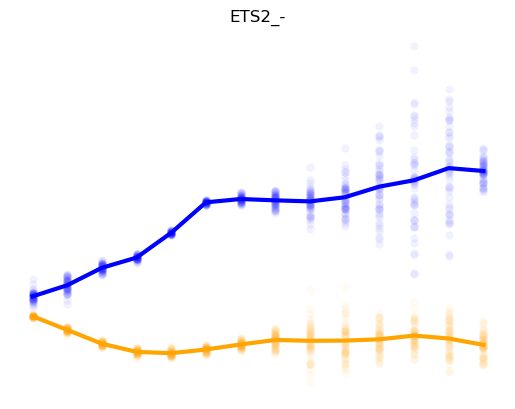

ETS2_+


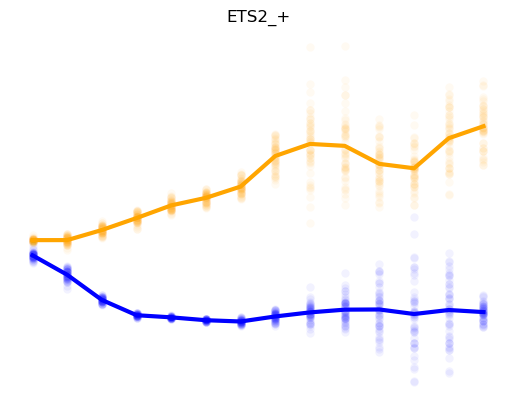

ETV6_+


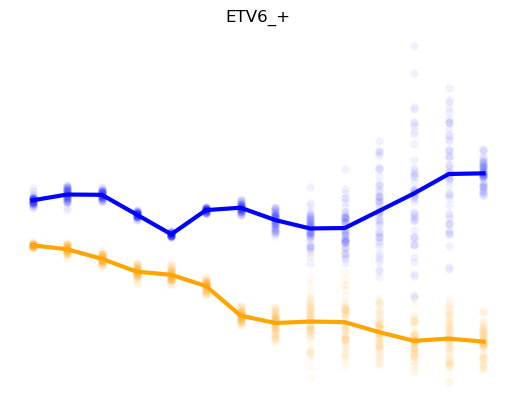

GATA5_+


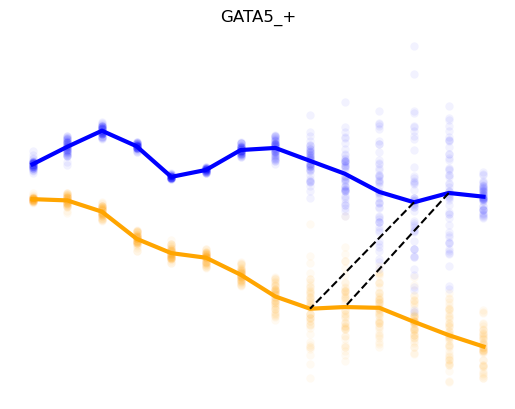

GATA4_+


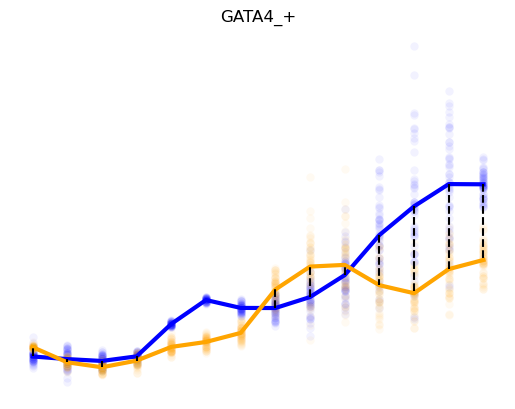

THRA_+


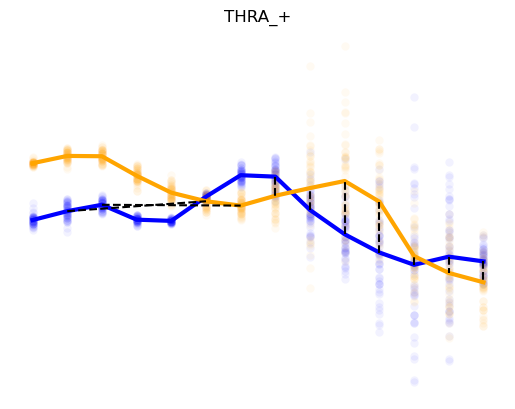

PITX2_+


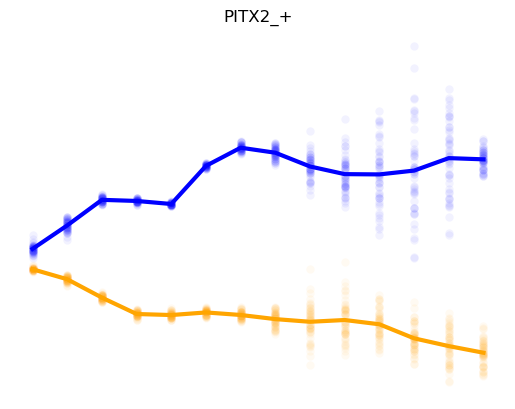

NKX2-5_extended_+


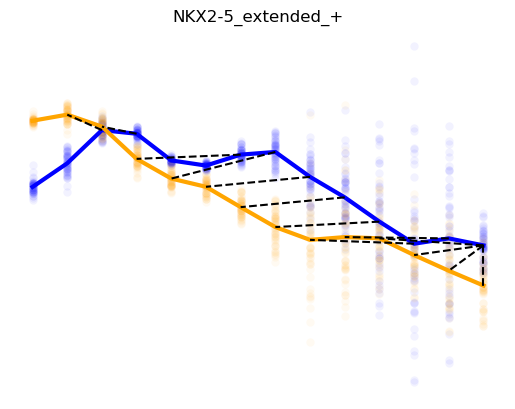

In [34]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in ['ETS2_-','ETS2_+','ETV6_+','GATA5_+','GATA4_+','THRA_+','PITX2_+','NKX2-5_extended_+']:
    print(gene)
    # Redirect the output of the plot function to a StringIO object
    f = io.StringIO()
    with redirect_stdout(f):
        #VisualUtils.plotTimeSeries(gene, aligner, vs)
        #VisualUtils.plotTimeSeriesAlignment(gene, aligner)
        plotTimeSeriesAlignment_cmap(gene, aligner)

    
    # Now, the plot is created and can be saved
    plt.savefig(f"{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

### Run gene set overrepresentation analysis over the top k mismatching genes

Let us use 30% alignment similarity (=0.3) as a threshold in this case

In [35]:
lowSimGenes = df[list(df['alignment_similarity_percentage'] < 0.5)]
topSimGenes = df[list(df['alignment_similarity_percentage'] > 0.35)]

### Clustering genes using their alignments

We first run cluster diagnostics to decide on a distance threshold with a good tradeoff between the number of clusters and the quality of structure. We use levenshtein distance metric

compute distance matrix
using levenshtein distance metric


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████                                   | 73/99 [00:00<00:00, 82.46it/s]


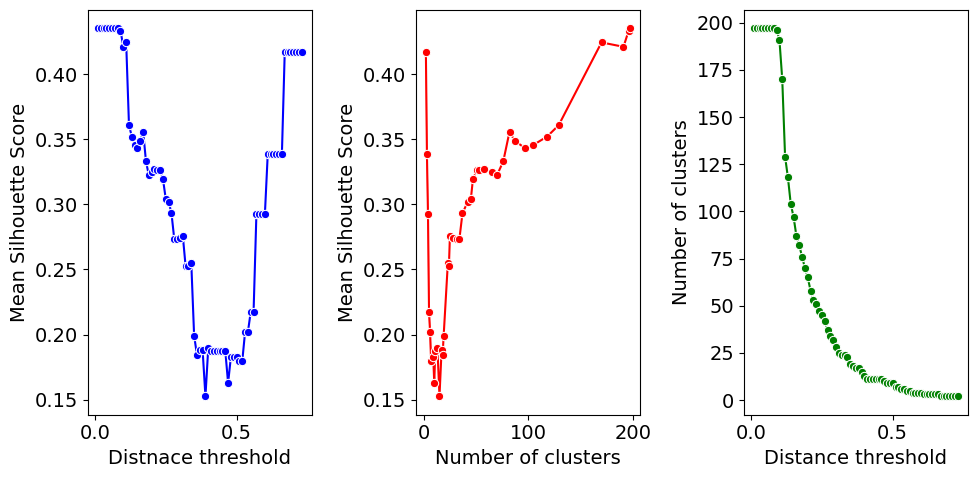

In [36]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 

We can inspect structures of distance thresholds that give local optimals of the mean silhouette score.

In [37]:
df.sort_values('Distance threshold', ascending=False)

Distance threshold  Mean Silhouette Score  Number of clusters
72                0.73               0.416776                 2.0
71                0.72               0.416776                 2.0
70                0.71               0.416776                 2.0
69                0.70               0.416776                 2.0
68                0.69               0.416776                 2.0
..                 ...                    ...                 ...
4                 0.05               0.435252               197.0
3                 0.04               0.435252               197.0
2                 0.03               0.435252               197.0
1                 0.02               0.435252               197.0
0                 0.01               0.435252               197.0

[73 rows x 3 columns]

If we select distance threshold 0.37 which gives a local optimal of 0.3749 silhouette_score with 7 clusters

In [38]:
aligner.show_ordered_alignments()

Gene               Alignment
-----------------  ----------------------------
ETS2_+             IIIDIDIDIDIIIIIIIIDDDDDDDDDD
ETS2_-             IIIDIDIDIDIIIIIIIIDDDDDDDDDD
ETV6_+             IIIDIDIDIDIIIIIIIIDDDDDDDDDD
MAF_-              IIIDIDIDIDIIIIIIIIDDDDDDDDDD
PITX2_+            IIIDIDIDIDIIIIIIIIDDDDDDDDDD
E4F1_+             MMMMMMMMMMMMMM
FOXN2_+            MMMMMMMMMMMMMM
IRF7_extended_+    MMMMMMMMMMMMMM
MLX_+              MMMMMMMMMMMMMM
NFYA_+             MMMMMMMMMMMMMM
PHF21A_extended_+  MMMMMMMMMMMMMM
TBP_+              MMMMMMMMMMMMMM
TFAP4_+            MMMMMMMMMMMMMM
TFCP2_+            MMMMMMMMMMMMMM
TFDP2_+            MMMMMMMMMMMMMM
ZBTB20_+           MMMMMMMMMMMMMM
ZNF200_+           MMMMMMMMMMMMMM
ZNF709_+           MMMMMMMMMMMMMM
ZNF526_+           MMWWWWWWIIIIIMMMMMIID
ZNF337_+           MVVVVVVDDDDDDMMMMMMM
PATZ1_+            MMMMMMIDIDMMMMMM
ZNF267_+           MMMVVVDIDDDMMMMMMM
ZNF639_+           MMMMMMIDIDMMMMMM
ZNF394_+           MMMMMIDMMMMMMMM
ZNF676_+       

31              ETS2_+
32              ETS2_-
35              ETV6_+
78               MAF_-
119            PITX2_+
            ...       
24              E2F6_+
203           ZNF219_+
242           ZNF549_+
139    SIX5_extended_+
44             GATA5_+
Name: genes, Length: 278, dtype: object

In [39]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.5) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.5
silhouette_score:  0.1830240565803321


Below visualizes all alignment paths in each cluster along with its number of genes 

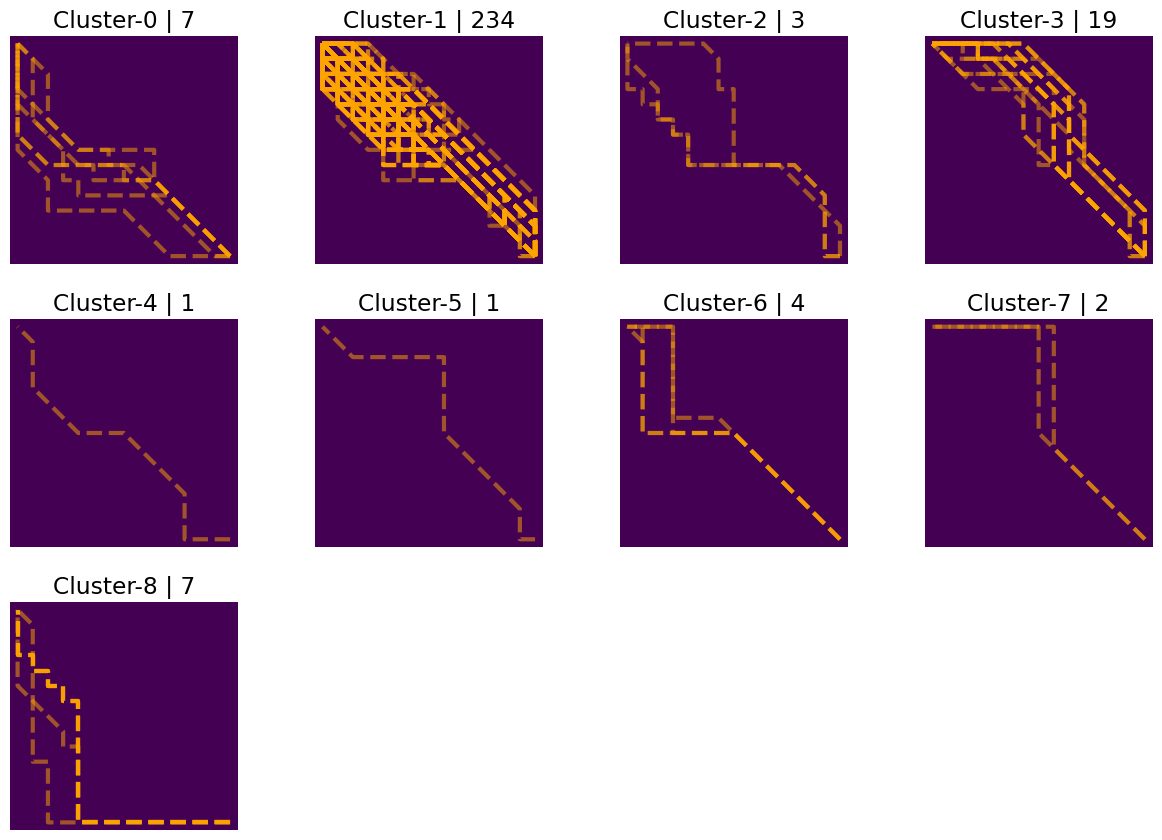

In [40]:
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (10,6))

In [41]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIIIIMMMIDDDDDDMMMMM 7
cluster:  1 IDMMMIIDDMMMMMMMM 234
cluster:  2 IIIDIDIDIDIIIIIIDDDDDDDMMD 3
cluster:  3 IIDDDDDDMMMIIIMVMMMM 19
cluster:  4 MIIIMMMIIDDDMMMMMDD 1
cluster:  5 DMDDDDMMIIIIIIMMMMMD 1
cluster:  6 IIIDIMIMDDDDMMMMMMM 4
cluster:  7 IIIDDDDDDMMVVMMMVMMM 2
cluster:  8 IIIDIDIDIDIIIIIIIIDDDDDDDDDD 7


### Below is the Levenshtein distance heat map of all genes ordered based on the above clustering structure

In [42]:
# Initialize an empty dictionary
cluster_genes_dict = {}

# Loop through each gene and its corresponding cluster ID
for gene, cluster_id in zip(aligner.gene_list, aligner.cluster_ids):
    # Check if the cluster ID is already in the dictionary
    if cluster_id not in cluster_genes_dict:
        # If not, create a new list for this cluster ID
        cluster_genes_dict[cluster_id] = []
    # Append the gene to the list for this cluster ID
    cluster_genes_dict[cluster_id].append(gene)

In [43]:
clus_of_interest=8

In [44]:
cluster_genes_dict[clus_of_interest]
print(len(cluster_genes_dict[clus_of_interest]))

7


Average Alignment:  IIIDIDIDIDIIIIIIIIDDDDDDDDDD


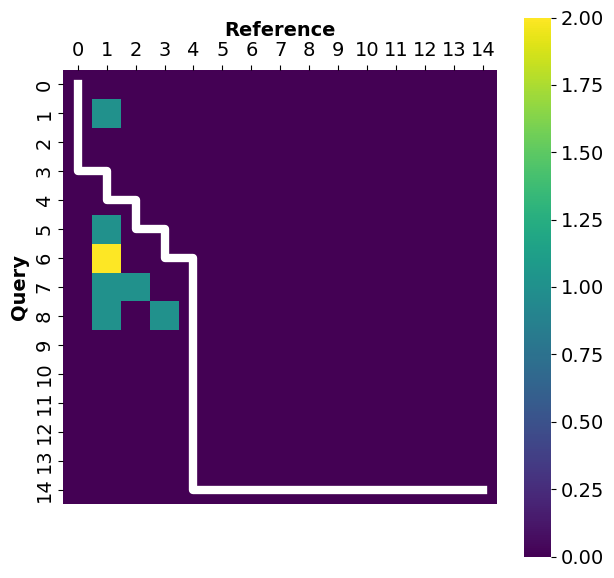

In [45]:
GENE_SUBSET = cluster_genes_dict[clus_of_interest]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

BHLHE41_+ MIIIVVVVIIDIIIIDDDDDDDDDDDD


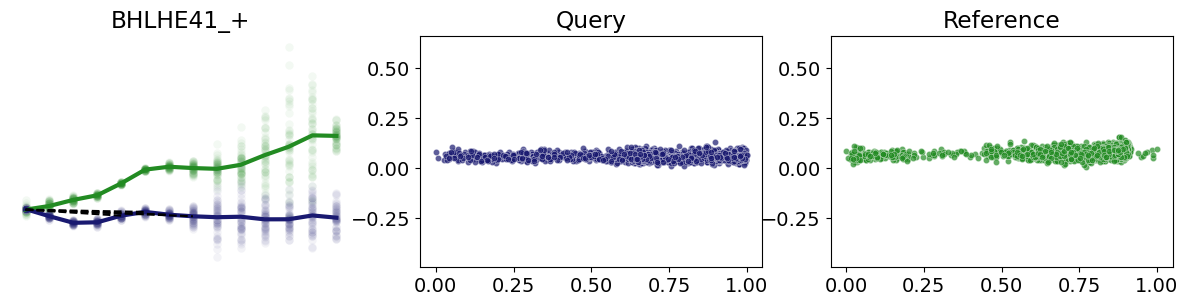

ETS2_+ IIIDIDIDIDIIIIIIIIDDDDDDDDDD


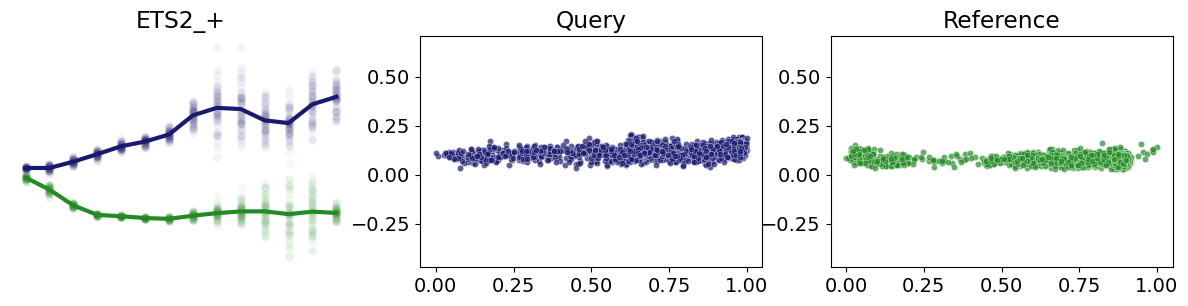

ETS2_- IIIDIDIDIDIIIIIIIIDDDDDDDDDD


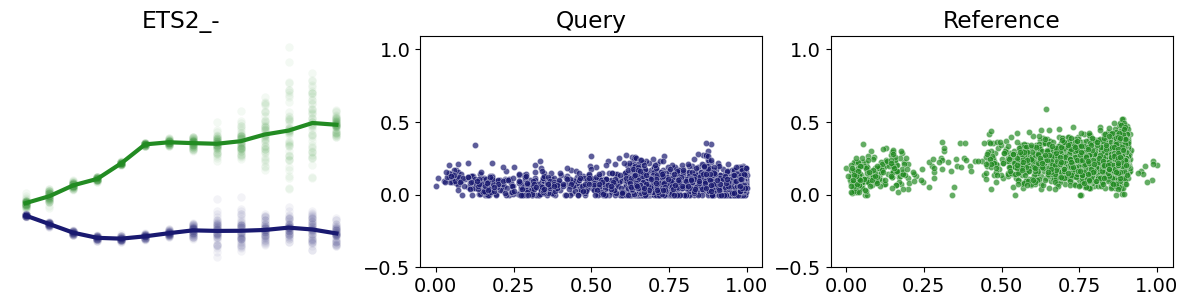

ETV6_+ IIIDIDIDIDIIIIIIIIDDDDDDDDDD


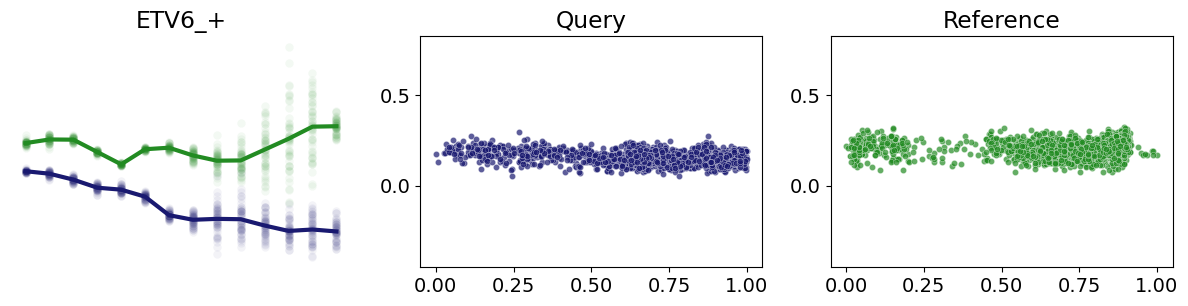

GTF2IRD1_+ IIIIIMMMIDIIIIIDDDDDDDDDD


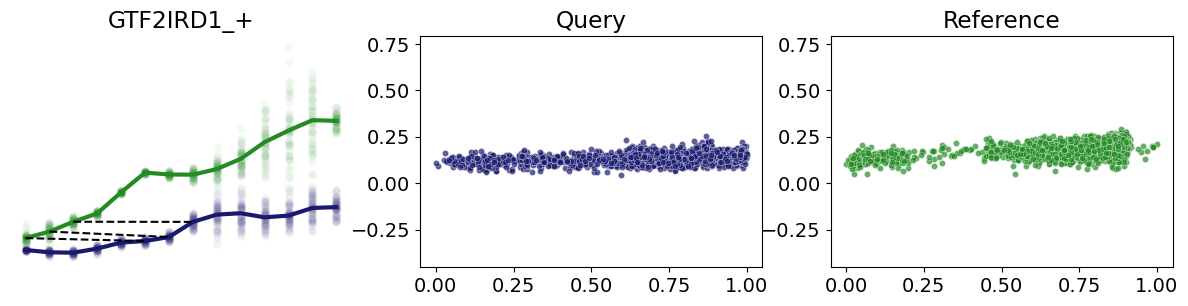

MAF_- IIIDIDIDIDIIIIIIIIDDDDDDDDDD


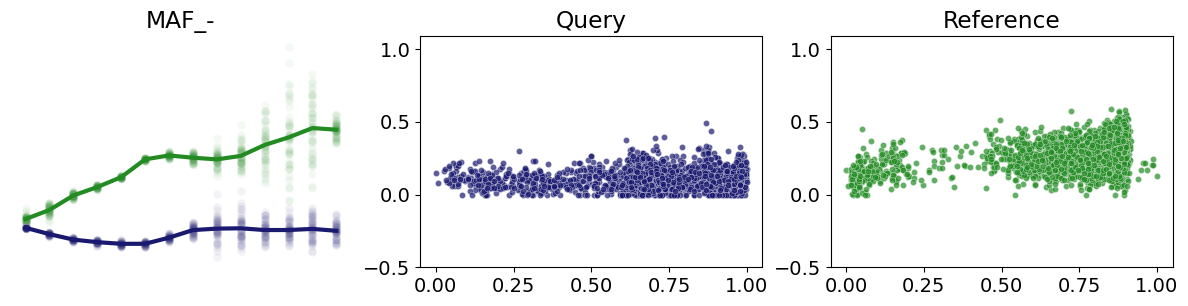

PITX2_+ IIIDIDIDIDIIIIIIIIDDDDDDDDDD


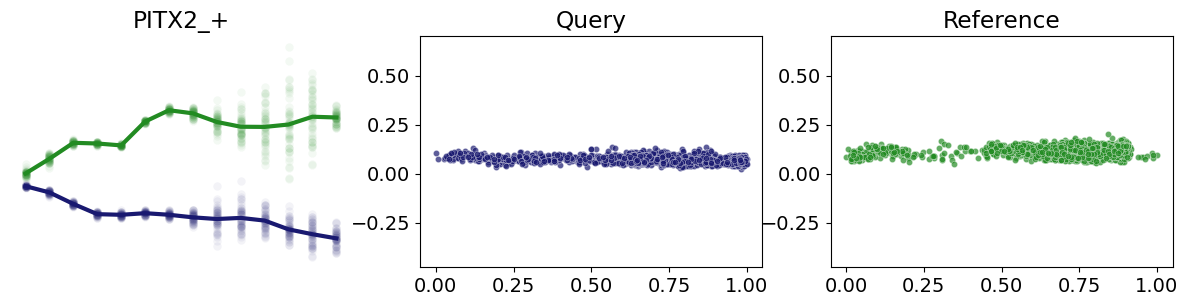

In [46]:
for gene in GENE_SUBSET:
    if len(GENE_SUBSET)<150:
        print(gene, aligner.results_map[gene].alignment_str)
        VisualUtils.plotTimeSeries(gene, aligner, vs)
        plt.show()

In [47]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

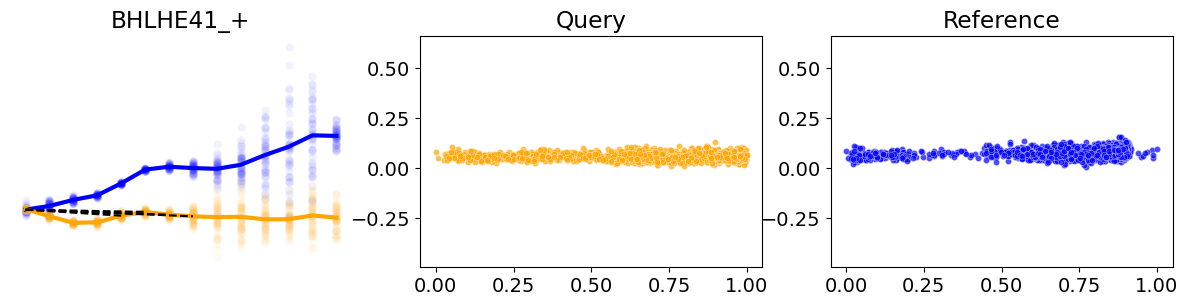

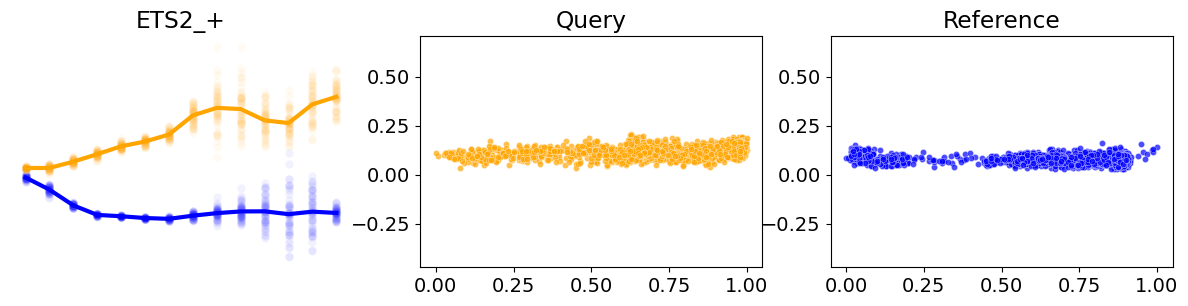

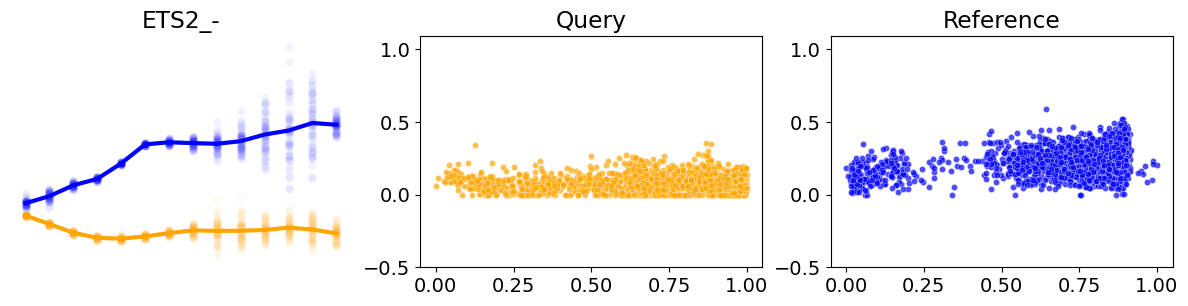

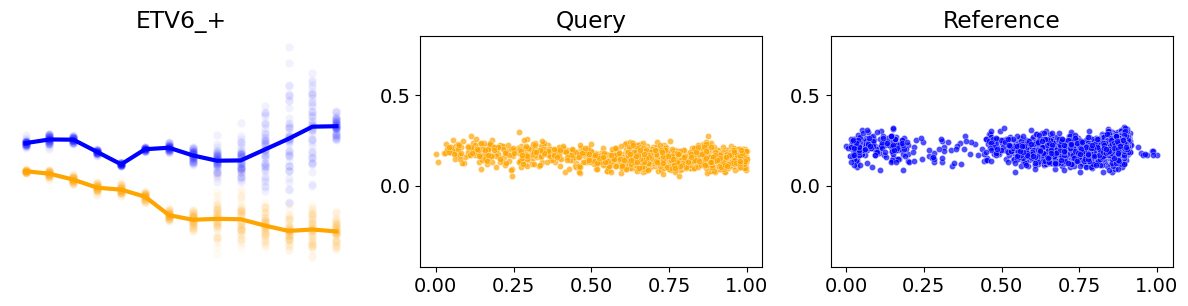

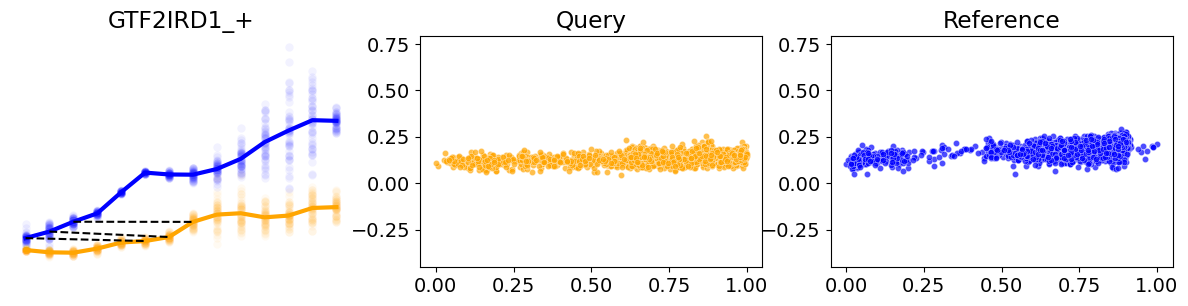

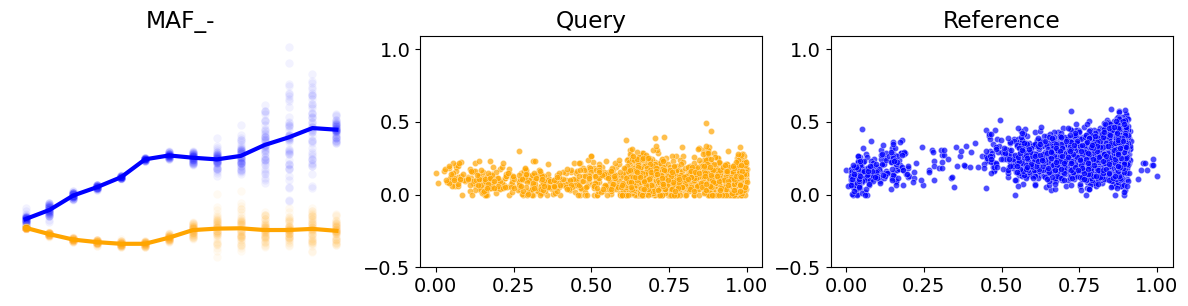

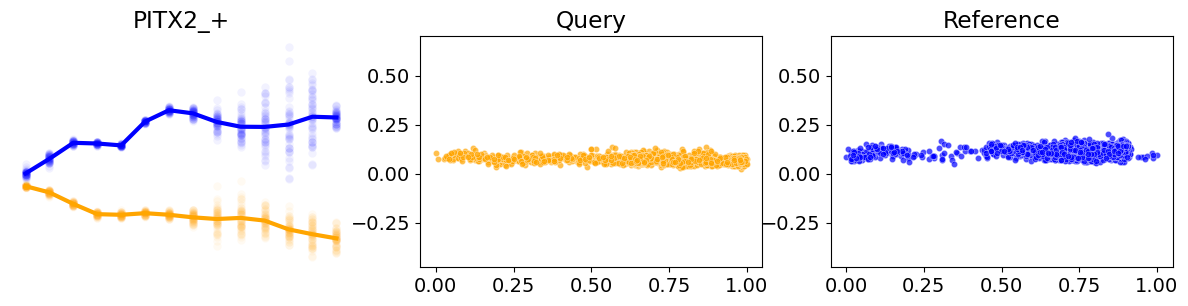

In [48]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in GENE_SUBSET:
    f = io.StringIO()
    with redirect_stdout(f):
        plotTimeSeries_cmap(gene, aligner)
    plt.savefig(f"./figures/{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

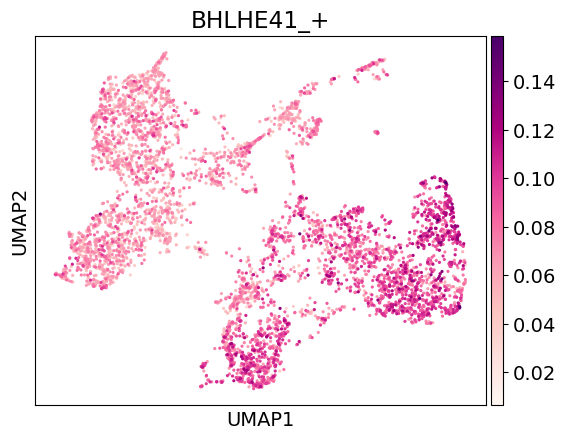

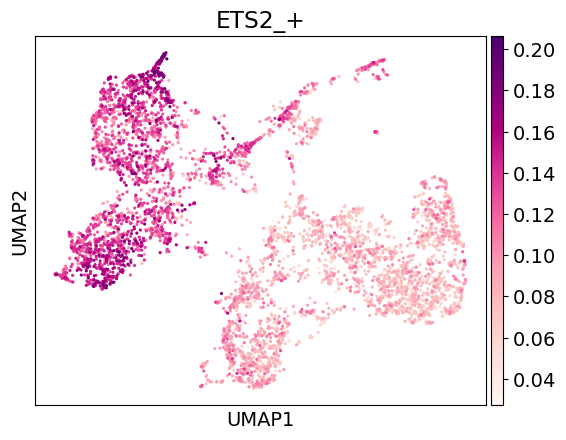

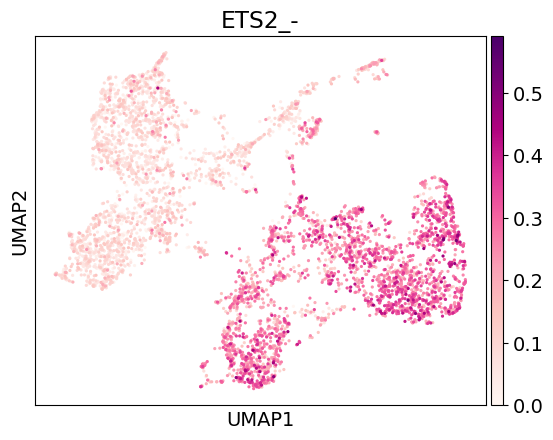

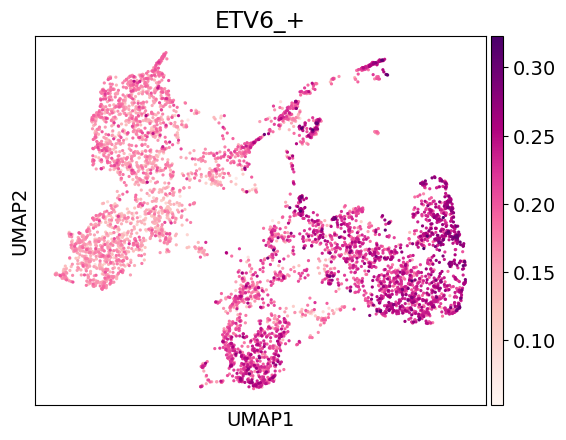

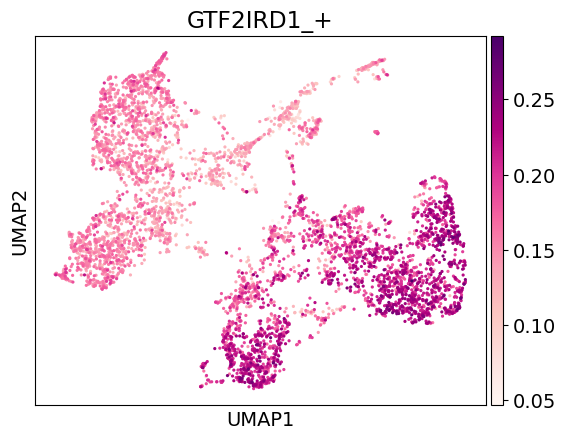

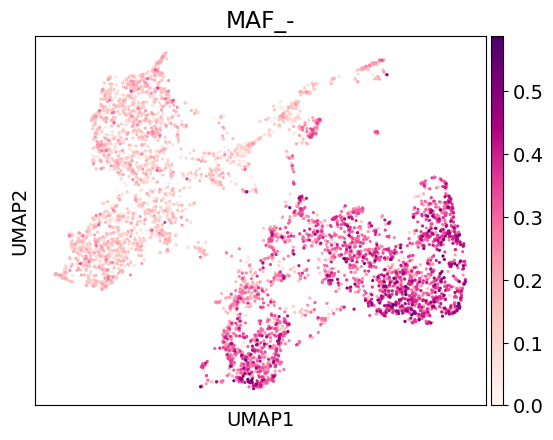

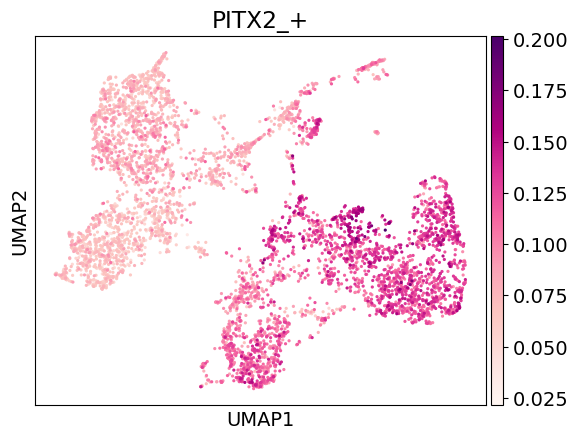

In [49]:
for gene in GENE_SUBSET:
    sc.pl.umap(adata_aucg,color=gene,cmap="RdPu",save=f"_{gene}_AUC.png")

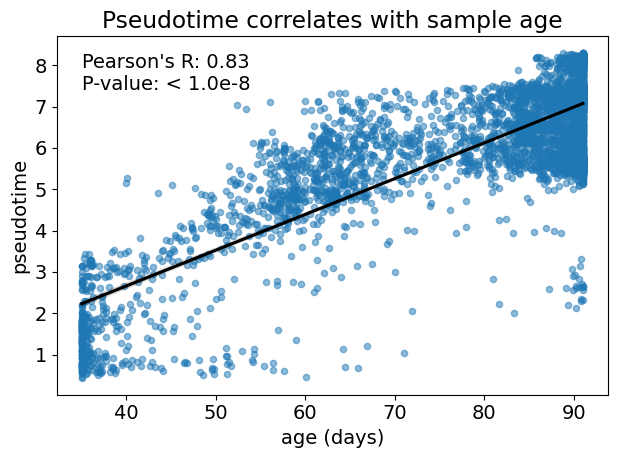

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming plot_data is defined as per your code snippet
plot_data = adata_aucg.obs[["t", "age_days_smoothed_once"]]

# Calculate Pearson's R and the p-value
pearson_r, p_value = pearsonr(plot_data['age_days_smoothed_once'], plot_data['t'])
p_value_text = f"{p_value:.2e}" if p_value > 1.0e-8 else "< 1.0e-8"

# Create scatter plot with specified aesthetics
sns.regplot(data=plot_data, x="age_days_smoothed_once", y="t", 
            scatter_kws={'alpha':0.5, 's':20, 'edgecolor':None},
            line_kws={'color':'black'}, # Sets the regression line color to black
            ci=95)

# Add text annotation for Pearson's R and adjusted p-value on the plot
plt.text(x=min(plot_data['age_days_smoothed_once']), y=max(plot_data['t']),
         s=f"Pearson's R: {pearson_r:.2f}\nP-value: {p_value_text}",
         backgroundcolor='white', ha='left', va='top')  # Adjust text positioning as needed
plt.xlabel("age (days)")
plt.ylabel("pseudotime")
plt.title('Pseudotime correlates with sample age')
plt.tight_layout()
plt.savefig(f"./figures/age_pseudotime_correlation.pdf", format='pdf', bbox_inches='tight')
plt.show()

mean matched percentage: 
60.519999999999996 %


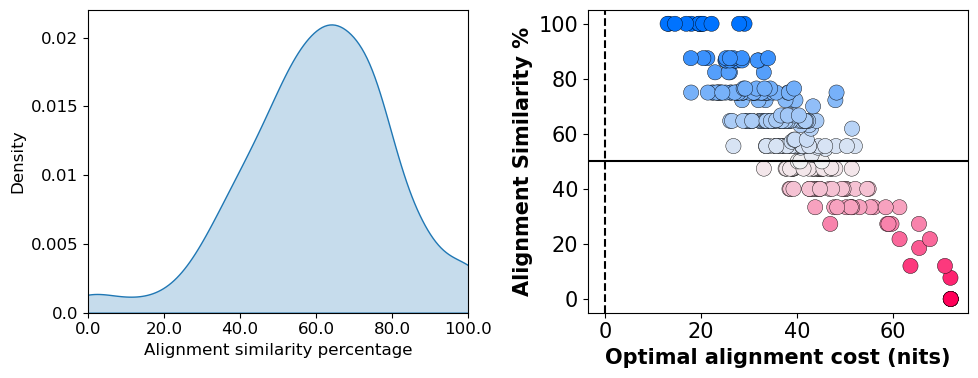

In [51]:
df = aligner.get_stat_df() 

In [52]:
df["alignment_similarity_percentage"] *= 100

In [53]:
filtered_df = df[df["alignment_similarity_percentage"] < 25]

# Sort primarily by 'l2fc' and secondarily by 'and_logfc', both in ascending order
sorted_df = filtered_df.sort_values(by=['l2fc'])
sorted_df

Gene alignment_similarity_percentage opt_alignment_cost  \
31            ETS2_+                             0.0          72.073285   
77             MAF_+                           21.74           67.73143   
57           IKZF2_+                            12.0          70.869309   
35            ETV6_+                             0.0          72.073285   
11         BHLHE41_+                           18.52          65.496091   
50        GTF2IRD1_+                            12.0          63.675774   
44           GATA5_+                            7.69          72.017812   
119          PITX2_+                             0.0          72.073285   
139  SIX5_extended_+                           21.74          61.395848   
78             MAF_-                             0.0          72.073285   
32            ETS2_-                             0.0          72.073285   

         l2fc color  abs_l2fc  
31  -0.687252   red  0.687252  
77  -0.555707   red  0.555707  
57    0.35381   red   0.35381  
35   0.439772   red  0.439772  
11    0.45052   red   0.45052  
50   0.452963   red  0.452963  
44   0.545917   red  0.545917  
119   0.68402   red   0.68402  
139  0.690589   red  0.690589  
78   1.296242   red  1.296242  
32   1.615218   red  1.615218

In [55]:
LOW_SIM_REGULONS = sorted_df['Gene'].unique().tolist()

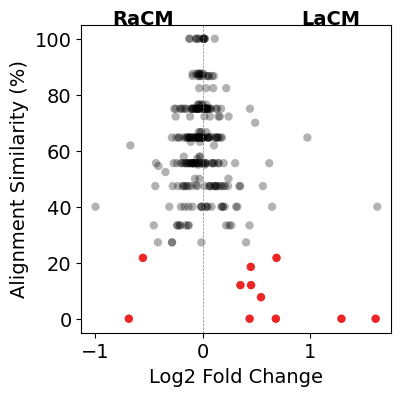

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

# Assuming 'df' is your DataFrame and 'genes_of_interest' is your list of genes
genes_of_interest = GENE_SUBSET

# Choose the y-axis based on your need
y_axis = 'alignment_similarity_percentage'  # or 'opt_alignment_cost'

# Plotting the scatter plot
sns.scatterplot(data=df, x='l2fc', y=y_axis, edgecolor="none", legend=False, alpha=0.3, color='black')
sns.scatterplot(data=df[df["Gene"].isin(LOW_SIM_REGULONS)], x='l2fc', y=y_axis, edgecolor="none", legend=False, color='red', alpha=0.8)

# Add a horizontal line at y=0.5
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')

# Label points corresponding to specific genes
#for _, row in df.iterrows():
#    if row['Gene'] in genes_of_interest:
#        plt.text(row['l2fc'], row[y_axis], row['Gene'], color='red', style='italic')

# Set labels
plt.xlabel("Log2 Fold Change")

if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")
elif y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Save the plot
plt.savefig("./figures/similarity_v_logFC_AUC.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


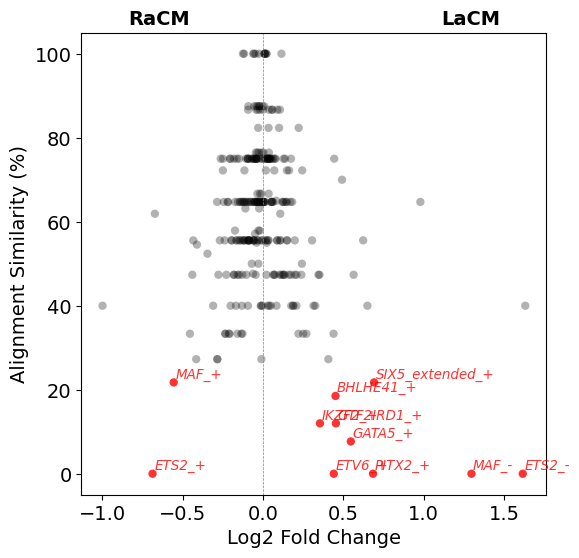

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Assuming 'df' is your DataFrame and 'genes_of_interest' is your list of genes
genes_of_interest = GENE_SUBSET  # Make sure this is defined as your subset of interest

# Choose the y-axis based on your need
y_axis = 'alignment_similarity_percentage'  # or 'opt_alignment_cost'

# Plotting the background scatter plot
sns.scatterplot(data=df[~df["Gene"].isin(LOW_SIM_REGULONS)], x='l2fc', y=y_axis, edgecolor="none", legend=False, alpha=0.3, color='black')
sns.scatterplot(data=df[df["Gene"].isin(LOW_SIM_REGULONS)], x='l2fc', y=y_axis, edgecolor="none", legend=False, color='red', alpha=0.8)

# Instead of plotting red points, we will annotate gene names directly on the plot for LOW_SIM_REGULONS
for _, row in df[df["Gene"].isin(LOW_SIM_REGULONS)].iterrows():
    plt.text(row['l2fc']+0.01, row[y_axis]+1, row['Gene'], color='red', style='italic', alpha=0.8, size='x-small')

# Add a horizontal line at y=0
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')

# Set labels
plt.xlabel("Log2 Fold Change")
if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")
elif y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Save the plot
plt.savefig("./figures/similarity_v_logFC_AUC.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


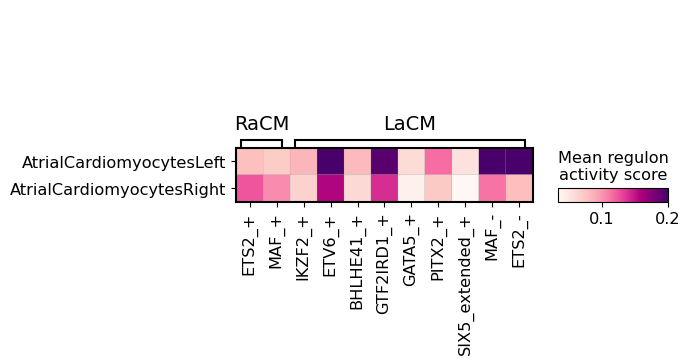

In [57]:
sc.pl.matrixplot(adata_aucg,
             var_names = LOW_SIM_REGULONS,
             groupby="fine_grain",
             colorbar_title="Mean regulon\nactivity score",
                save="_RAS_LvRaCMs.pdf",
                cmap="RdPu",
                vmax=0.2,
                var_group_positions=[(0,1),(2,10)],
             var_group_labels=["RaCM","LaCM"])

In [62]:
adata_aucg.obs['t'] = pd.to_numeric(adata_aucg.obs['t'])
adata_aucg = adata_aucg[adata_aucg.obs['t'].sort_values().index]

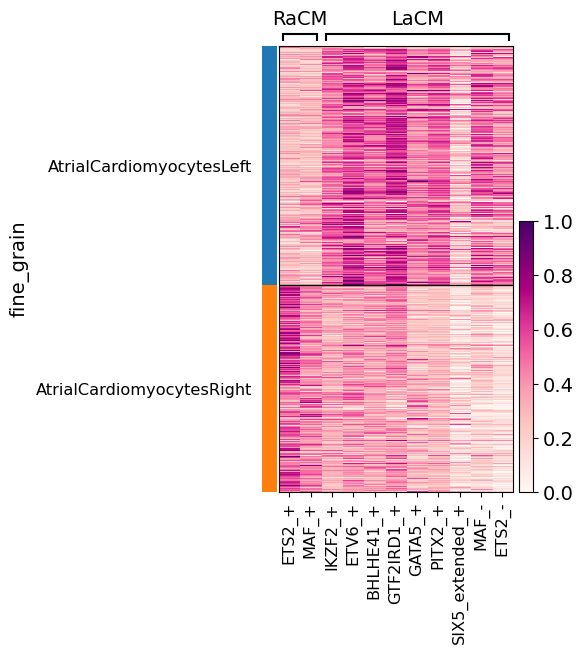

In [63]:
sc.pl.heatmap(adata_aucg,var_names = LOW_SIM_REGULONS,
             groupby="fine_grain",
             standard_scale='var',
             cmap='RdPu',
              var_group_positions=[(0,1),(2,10)],
             var_group_labels=["RaCM","LaCM"],
              save="_RAS_LvRaCMs.pdf",
             )

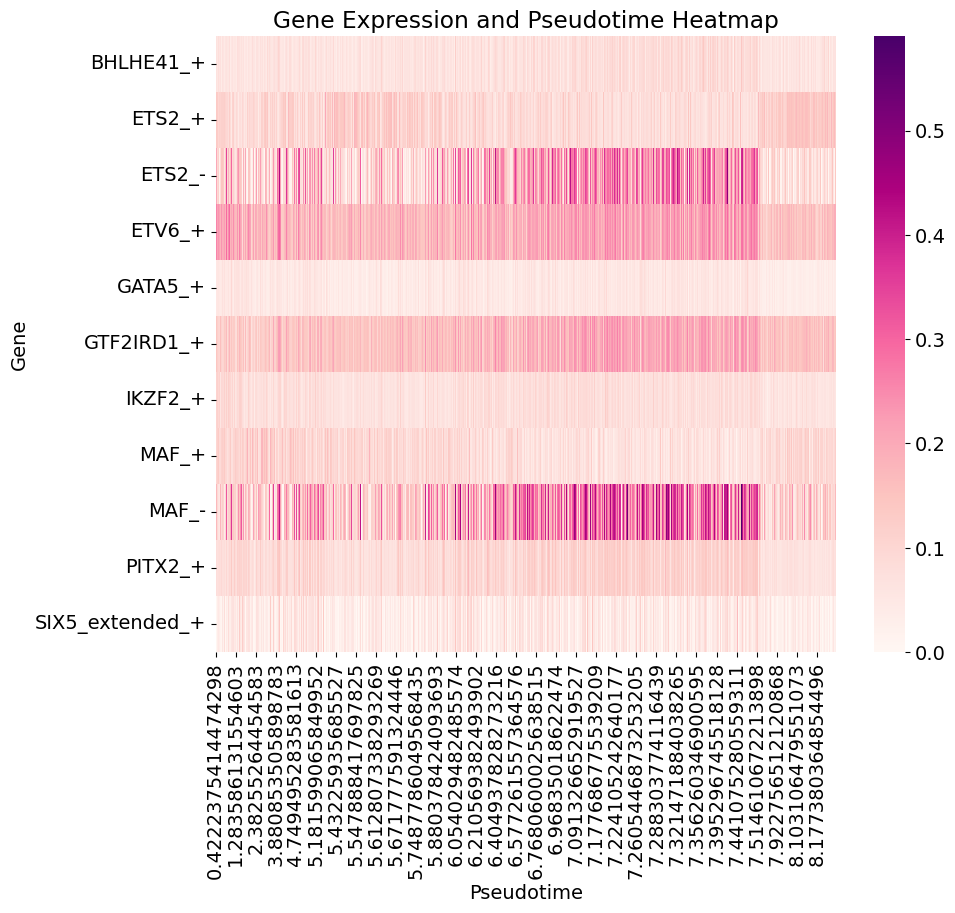

In [66]:
import scipy
# Extract the expression data for these genes
expression_data = adata_aucg[:, LOW_SIM_REGULONS].X

# Depending on the AnnData storage, the expression data might need conversion to a dense format
if scipy.sparse.issparse(expression_data):
    expression_data = expression_data.toarray()

# Create a DataFrame with the expression data
df_expression = pd.DataFrame(expression_data, columns=LOW_SIM_REGULONS)

# Add the pseudotime to the DataFrame
df_expression['pseudotime'] = adata_aucg.obs['t'].values

# Optionally, add your 'fine_grain' cluster information if you want to plot clusters in order
df_expression['fine_grain'] = adata_aucg.obs['fine_grain'].values

# Melt the DataFrame for easier plotting with seaborn
df_melted = df_expression.melt(id_vars=['pseudotime', 'fine_grain'], var_name='Gene', value_name='Expression')

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_melted.pivot_table(index='Gene', columns='pseudotime', values='Expression'), cmap='RdPu')

plt.title('Gene Expression and Pseudotime Heatmap')
plt.xlabel('Pseudotime')
plt.ylabel('Gene')
plt.show()

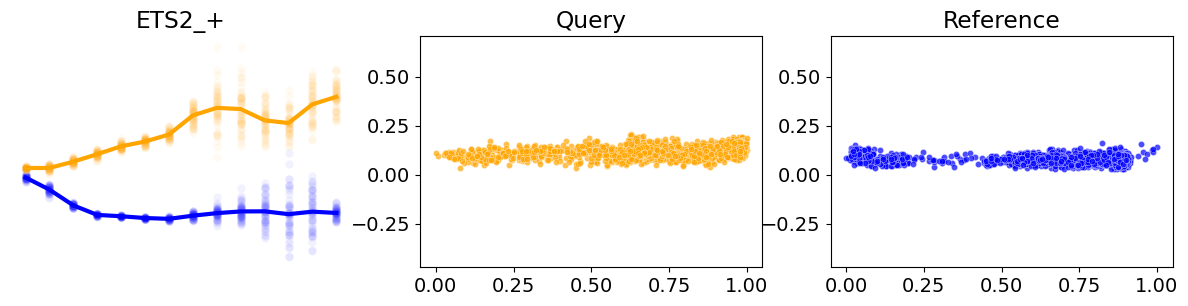

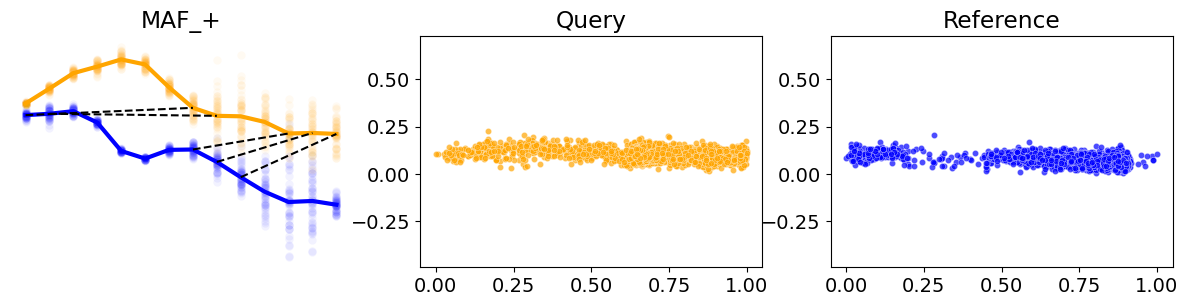

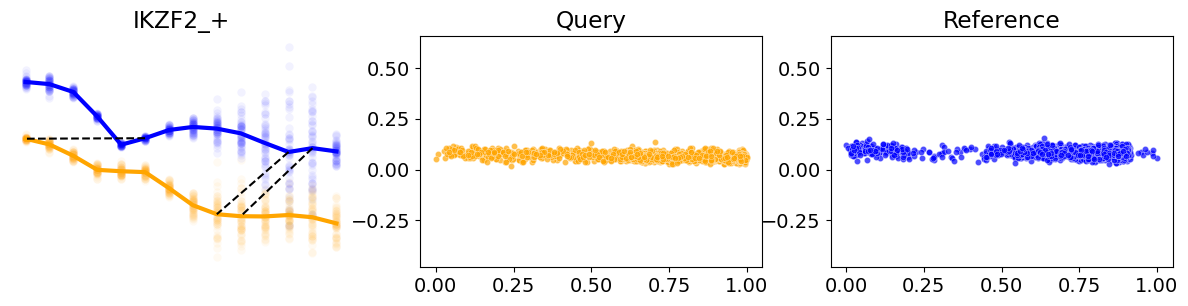

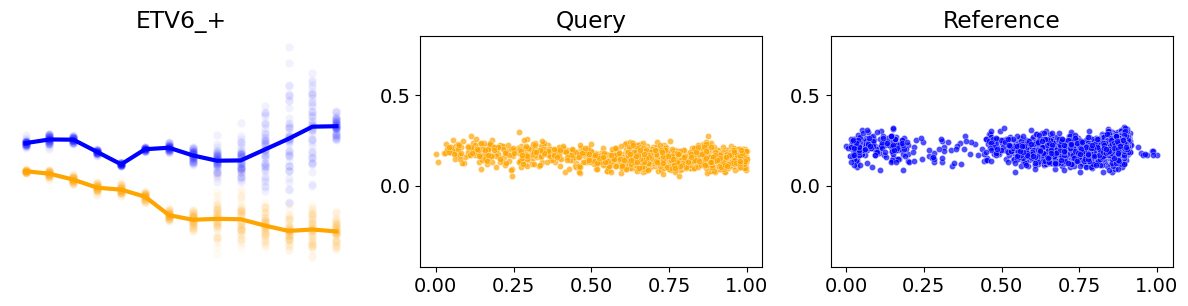

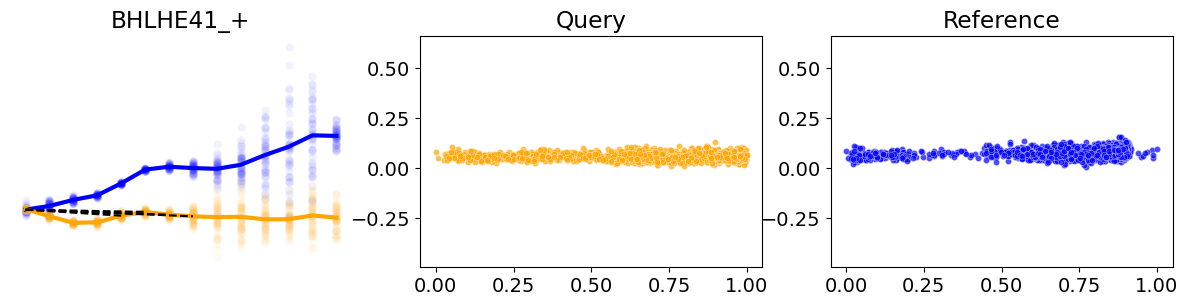

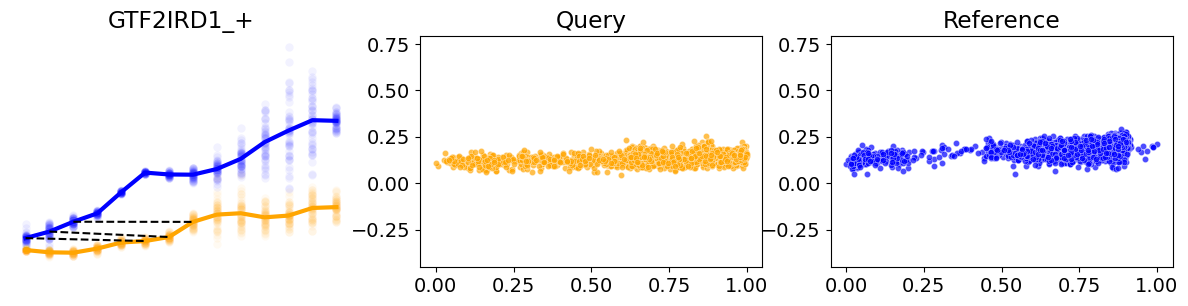

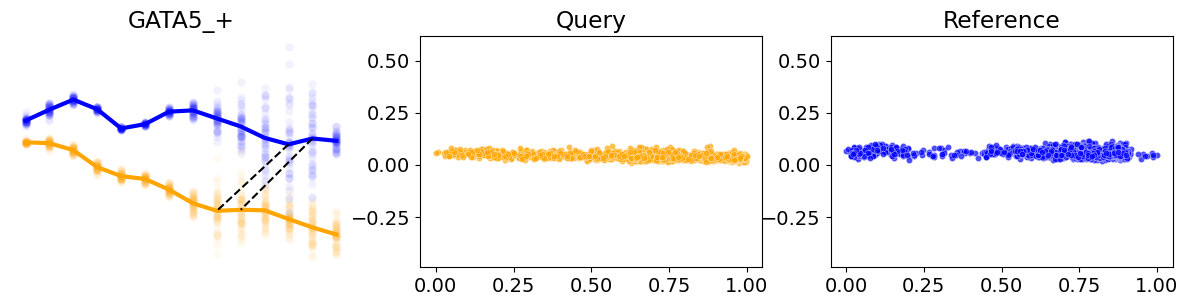

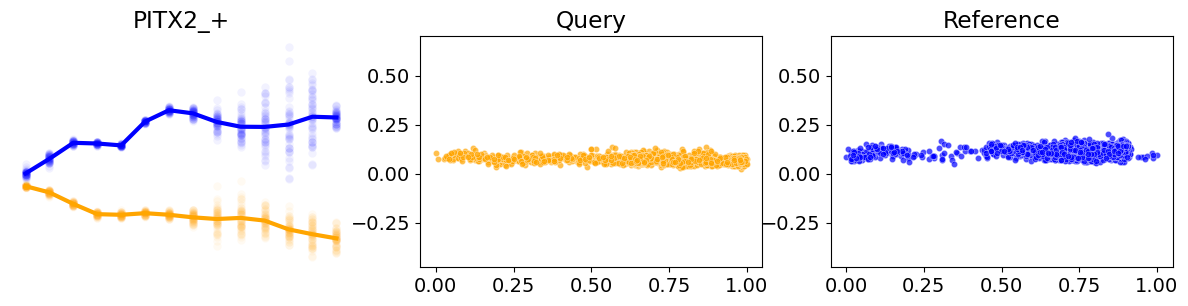

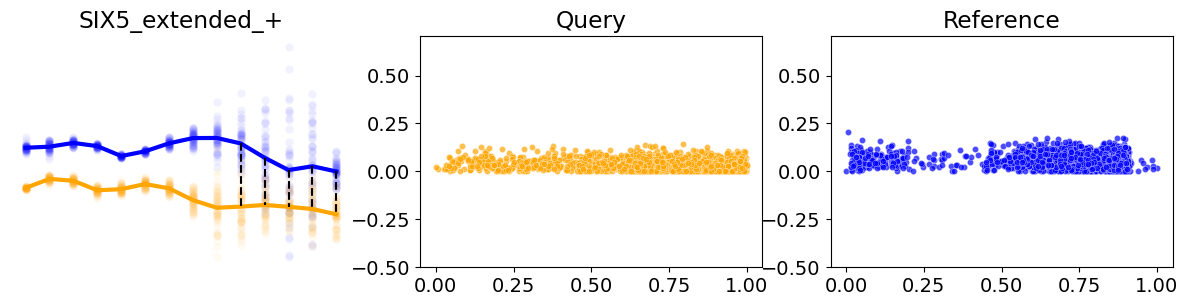

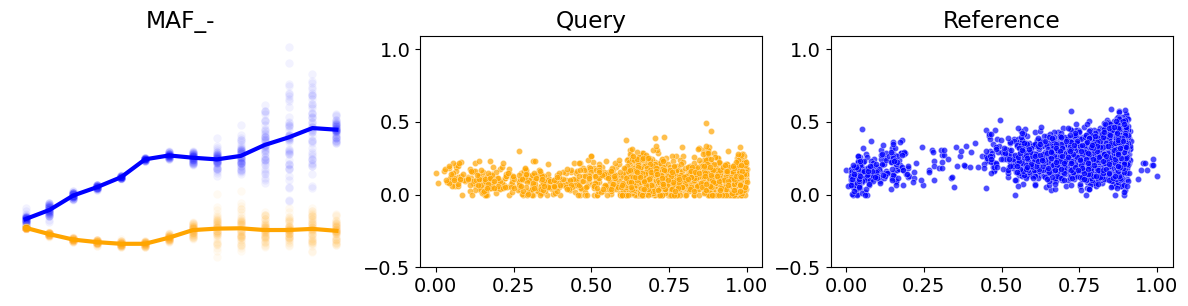

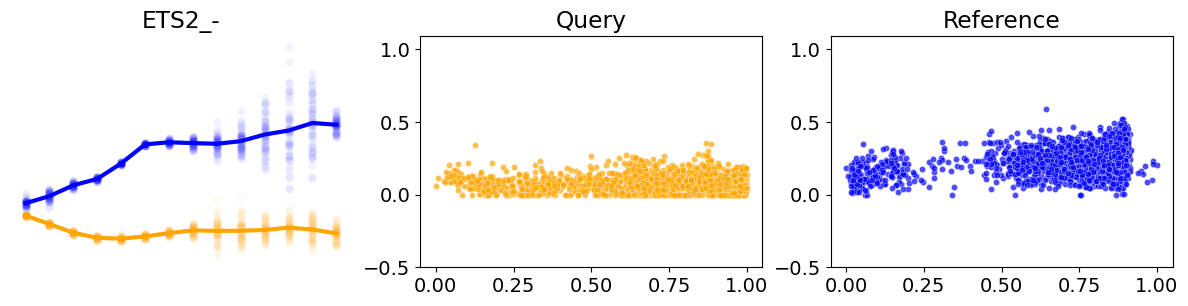

In [59]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in LOW_SIM_REGULONS:
    f = io.StringIO()
    with redirect_stdout(f):
        plotTimeSeries_cmap(gene, aligner)
    plt.savefig(f"./figures/{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

In [60]:
LOW_SIM_REGULONS

['ETS2_+',
 'MAF_+',
 'IKZF2_+',
 'ETV6_+',
 'BHLHE41_+',
 'GTF2IRD1_+',
 'GATA5_+',
 'PITX2_+',
 'SIX5_extended_+',
 'MAF_-',
 'ETS2_-']

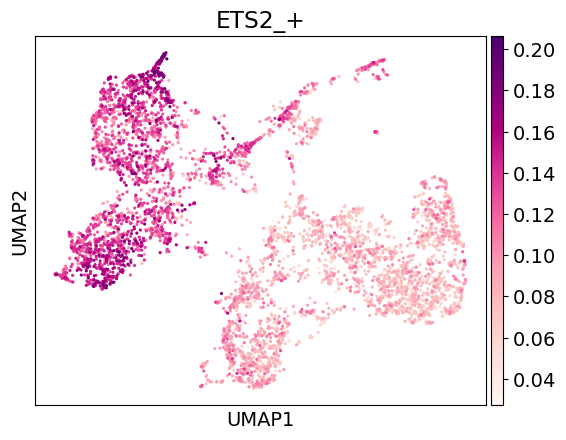

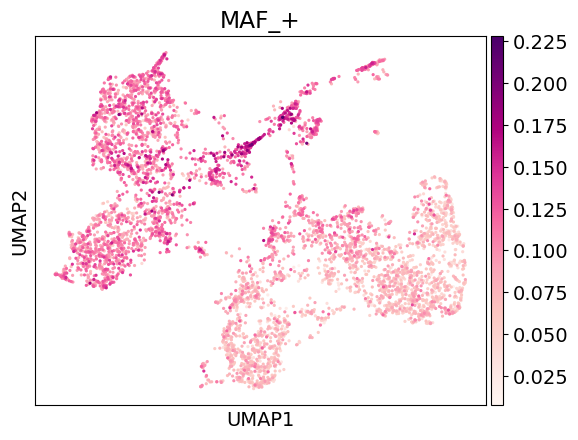

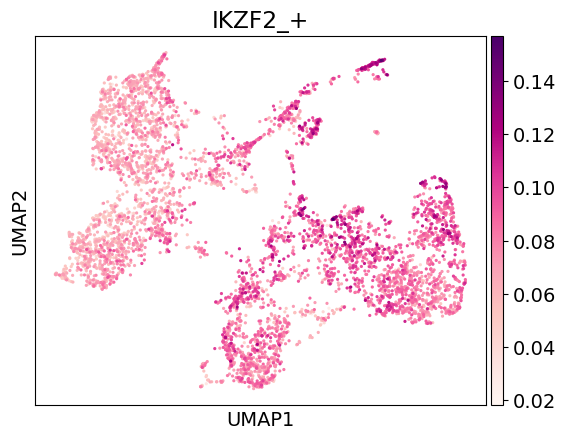

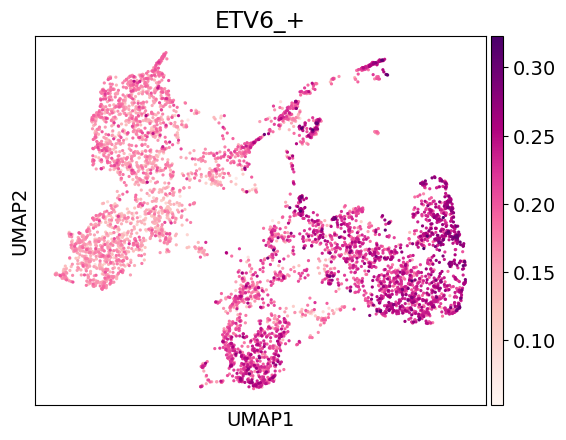

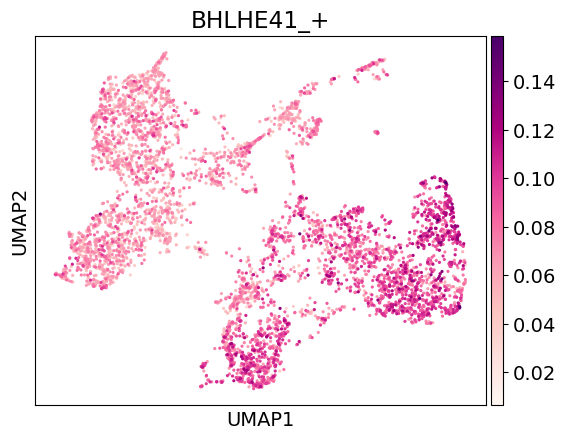

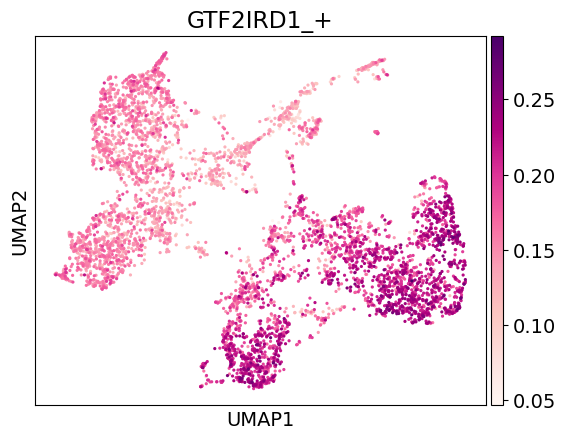

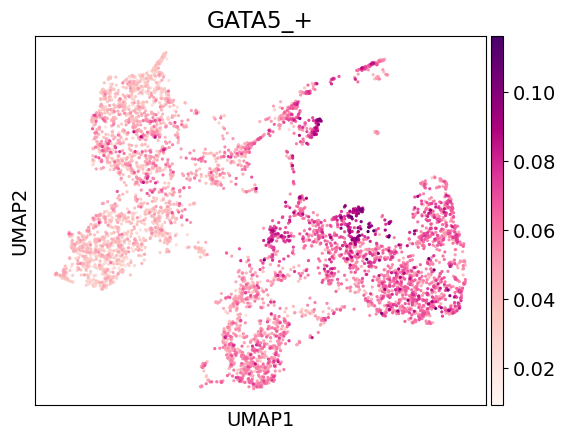

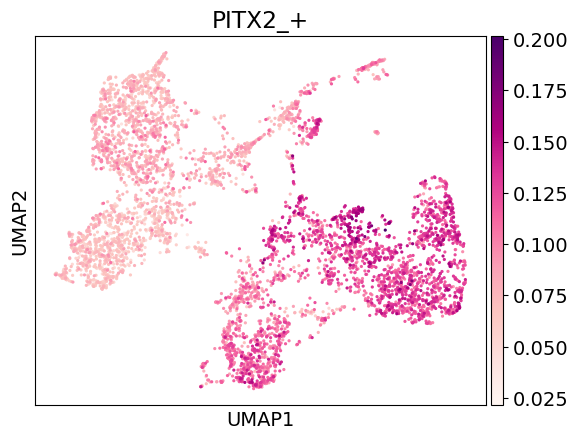

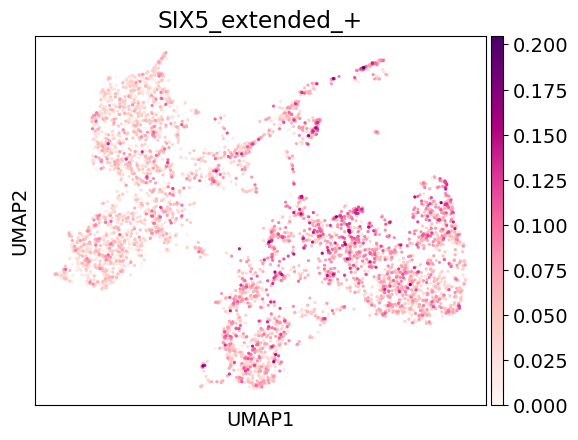

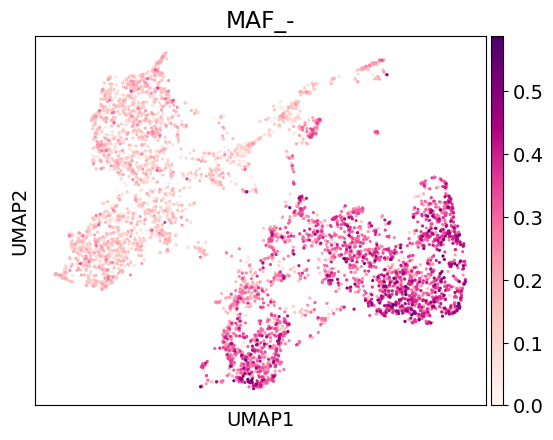

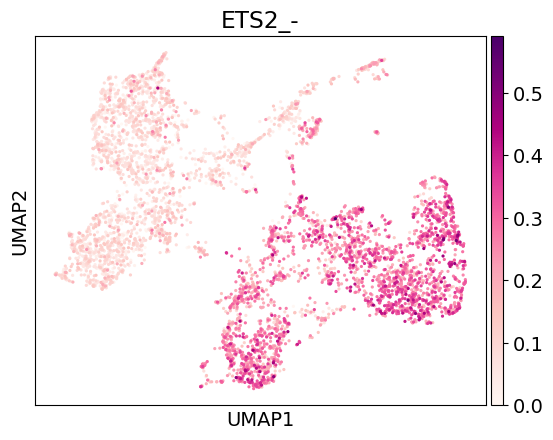

In [61]:
for gene in LOW_SIM_REGULONS:
    sc.pl.umap(adata_aucg,color=gene,cmap="RdPu",save=f"_{gene}_AUC.png")